# start

from mdl0402_3__xgb_mean_encode_5e5;

feature experiments with mean encoding

In [1]:
PRFX='mdl0404_1'

trntmstmp=1584412344
valtmstmp=1585761578

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_val_min,tm_val_max=(1581552000, 1582156799)

SEED=101

valsz = int(10)
trnsz = int(1e4)#int(5e5)

train_total=int(1.5e8)
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, valtmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_val_min,tm_val_max)])

train_total 150,000,000, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-01 17:19:38']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_follower_cnt','u2_following_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
print(tgt2col)
ntgts=len(tgts)

{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
%%time
dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz,nrows=trnsz)

CPU times: user 65.7 ms, sys: 16.3 ms, total: 82 ms
Wall time: 81 ms


In [4]:
lst_hshtgs = dftrn.hshtgs[dftrn.hshtgs.notna()].apply(lambda x: x.split('\t'))
hstgs_all = [j for i in lst_hshtgs for j in i]
hshtg2cnt = Counter(hstgs_all)
ttl=len(dftrn)
hshtg2frq = {k:v/ttl for k,v in hshtg2cnt.items()}
Counter(hshtg2frq).most_common(10)

[('B6024D6F02AFAF9BC8ED941F72C228F1', 0.0031),
 ('5671B8B6E92C2A316C05A7CD2F17366C', 0.0023),
 ('18F6AC96A6EA62716A47DE9FE6241534', 0.0013),
 ('E78674D323461112D0DCF8010AF5AED3', 0.0011),
 ('746E379897167C3B81A180BF8BAADD8D', 0.001),
 ('F564E2BDCB9A0ABADDD4A9EE053DFCD2', 0.0009),
 ('31C316EB7BB8CD1778CB83B8AA2603D9', 0.0009),
 ('F3A652C947EB7F5D093A48E95EFC62F5', 0.0008),
 ('DC286E92F82ADF9A92C522D3634F83A9', 0.0008),
 ('1E8BB1B1D7FB3FB8DF86A9AC39E5CBFD', 0.0007)]

In [5]:
lst_links = dftrn.links[dftrn.links.notna()].apply(lambda x: x.split('\t'))
hstgs_all = [j for i in lst_links for j in i]
link2cnt = Counter(hstgs_all)
ttl=len(dftrn)
link2frq = {k:v/ttl for k,v in link2cnt.items()}
display(link2cnt.most_common(10))
Counter(link2frq).most_common(10)

[('E522B6C629B01DA6B29DE65BF5DFA55B', 5),
 ('D6AFAE10A19940A31993C825F894AC7C', 3),
 ('3FD36B83A8719C0BE47C207D24268A61', 2),
 ('EAA99F88557400B2994AEF24D6E64722', 2),
 ('DEA673FD63DDDC8A3606106D5CA235B0', 2),
 ('B75301E7ABF4740CC8BDD16C0456AFCA', 2),
 ('E6D2A058726F4027E9A284D0A6537D74', 2),
 ('B5608EC4BBA13BA4151D9892AE9F0762', 2),
 ('D1228EF53E0B1E5D016862D778680603', 2),
 ('9EB5656FE135F5F180B9FCF919826F08', 2)]

[('E522B6C629B01DA6B29DE65BF5DFA55B', 0.0005),
 ('D6AFAE10A19940A31993C825F894AC7C', 0.0003),
 ('3FD36B83A8719C0BE47C207D24268A61', 0.0002),
 ('EAA99F88557400B2994AEF24D6E64722', 0.0002),
 ('DEA673FD63DDDC8A3606106D5CA235B0', 0.0002),
 ('B75301E7ABF4740CC8BDD16C0456AFCA', 0.0002),
 ('E6D2A058726F4027E9A284D0A6537D74', 0.0002),
 ('B5608EC4BBA13BA4151D9892AE9F0762', 0.0002),
 ('D1228EF53E0B1E5D016862D778680603', 0.0002),
 ('9EB5656FE135F5F180B9FCF919826F08', 0.0002)]

In [6]:
lst_domns = dftrn.domns[dftrn.domns.notna()].apply(lambda x: x.split('\t'))
domns_all = [j for i in lst_domns for j in i]
domn2cnt = Counter(domns_all)
ttl=len(dftrn)
domn2frq = {k:v/ttl for k,v in domn2cnt.items()}
display(domn2cnt.most_common(10))
Counter(domn2frq).most_common(10)

[('3896E26D12C903F0A00B6B1BE9A9BEA3', 146),
 ('E91CDEC8DC7ABF30592FA024616FF970', 78),
 ('FECA6F2E8244F2294BD2CE957C0602A9', 69),
 ('A32007FFB62B2DFC4E449BD37F985C53', 31),
 ('FCA72262B99BB78F010B25C882A0C93C', 31),
 ('9E34EBC679CA0BC677D198BEE3E37113', 24),
 ('A898ECD422D0575A276A0D74CD01C867', 24),
 ('BBA1D3359A23689C6783652EA73B12BA', 19),
 ('D0120C5A771484D1765BBA60461666B9', 16),
 ('C0F5328C1D36CD4B34D1808012E18D46', 12)]

[('3896E26D12C903F0A00B6B1BE9A9BEA3', 0.0146),
 ('E91CDEC8DC7ABF30592FA024616FF970', 0.0078),
 ('FECA6F2E8244F2294BD2CE957C0602A9', 0.0069),
 ('A32007FFB62B2DFC4E449BD37F985C53', 0.0031),
 ('FCA72262B99BB78F010B25C882A0C93C', 0.0031),
 ('9E34EBC679CA0BC677D198BEE3E37113', 0.0024),
 ('A898ECD422D0575A276A0D74CD01C867', 0.0024),
 ('BBA1D3359A23689C6783652EA73B12BA', 0.0019),
 ('D0120C5A771484D1765BBA60461666B9', 0.0016),
 ('C0F5328C1D36CD4B34D1808012E18D46', 0.0012)]

In [7]:
twttyps=['TopLevel','Retweet','Quote']

lang2freq=dict(dftrn.lang.value_counts()/len(dftrn))
langs2feat=[k for k,v in lang2freq.items() if v>=0.01]
len(langs2feat)

11

In [8]:
lens_hshtgs = dftrn.hshtgs.fillna('').apply(lambda x: len(x.split()))
sorted(Counter(lens_hshtgs).most_common(10))

[(0, 8026),
 (1, 1106),
 (2, 461),
 (3, 192),
 (4, 88),
 (5, 45),
 (6, 30),
 (7, 21),
 (8, 19),
 (10, 4)]

In [9]:
lens_links = dftrn.links.fillna('').apply(lambda x: len(x.split()))
sorted(Counter(lens_links).most_common())

[(0, 8636), (1, 1317), (2, 39), (3, 6), (4, 1), (5, 1)]

In [10]:
lens_domns = dftrn.domns.fillna('').apply(lambda x: len(x.split()))
sorted(Counter(lens_domns).most_common())

[(0, 8636), (1, 1317), (2, 39), (3, 6), (4, 1), (5, 1)]

In [11]:
def prp_tm(df, col):
    dt=pd.to_datetime(df[col], unit='s')
    df[col+'_dayofweek']=dt.dt.dayofweek
    df[col+'_hour']=dt.dt.hour

def prpdf(df,istrn=True,debug=False):
    tags = ['hshtgs','media','links','domns',]
    for tag in tags:
        df[f'has_{tag}']=df[tag].notna()
        df[tag]=df[tag].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tag}']=df[tag].apply(len)
    
    df['sum_frq_hshtg']=df['hshtgs'].apply(lambda x: sum([hshtg2frq.get(o,0) for o in x]))
    df['max_frq_hshtg']=df['hshtgs'].apply(lambda x: max([hshtg2frq.get(o,0) for o in x]) if len(x) else 0)
    df['sum_frq_domn']=df['domns'].apply(lambda x: sum([domn2frq.get(o,0) for o in x]))
    df['max_frq_domn']=df['domns'].apply(lambda x: max([domn2frq.get(o,0) for o in x]) if len(x) else 0)
        
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].apply(lambda x: x.count(m))
    
    df['toks']=df.toks.apply(lambda x: x.split('\t'))
    df['len_toks']=df.toks.apply(len)
    
    prp_tm(df, 'tm')
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm
    if istrn:
        df['tmleft_twt']   = tm_trn_max-df.tm
        df['tmleft_u1']    = tm_trn_max-df.u1_create_tm
        df['tmleft_u2']    = tm_trn_max-df.u2_create_tm
    else:
        df['tmleft_twt']   = tm_val_max-df.tm
        df['tmleft_u1']    = tm_val_max-df.u1_create_tm
        df['tmleft_u2']    = tm_val_max-df.u2_create_tm

    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs2feat:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    
    df['u1u2']=df.u1id+'_'+df.u2id
    ce_features = ['lang', 'u1id', 'u2id', 'u1u2', 'twtid']
    cnt_encd = ce.CountEncoder()
    cnt_encded = cnt_encd.fit_transform(df[ce_features])
    cnt_encded = cnt_encded.astype(int)
    cnt_encded = cnt_encded/len(df)
    cnt_encded.columns = [f'{col}_freq' for col in ce_features]
    df = pd.concat([df,cnt_encded],1)

    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna()
        if not debug: df.drop(inplace=True, columns=['toks','media','links','twttyp', 
                                       'tm','u1_create_tm','u2_create_tm','u1u2','u1id','u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        if not debug: df.drop(inplace=True, columns=['toks','media','links','twttyp', 
                                       'tm','u1_create_tm','u2_create_tm','u1u2','u1id', ])        
    return df    

In [12]:
%%time
dftrn = prpdf(dftrn)

CPU times: user 282 ms, sys: 44.5 ms, total: 327 ms
Wall time: 322 ms


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


In [13]:
# verify preprocess
# dftrn = prpdf(dftrn, debug=True)
# display(dftrn[['media','n_media_Photo', 'n_media_Video', 'n_media_GIF',]].sample(5))
# display(dftrn[['hshtgs','has_hshtgs', 'n_hshtgs', 'sum_frq_hshtg', 'max_frq_hshtg']].sample(5))
# display(dftrn[['domns','has_domns', 'n_domns', 'sum_frq_domn', 'max_frq_domn']].sample(5))

In [14]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)

CPU times: user 8.58 ms, sys: 47 µs, total: 8.63 ms
Wall time: 7.36 ms


In [15]:
%%time
dfval = prpdf(dfval)

CPU times: user 84.3 ms, sys: 649 µs, total: 84.9 ms
Wall time: 75.4 ms


## tr vl split

In [16]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()

## mean encoding

### lang

In [17]:
dftr.shape,dfvl.shape

((8521, 57), (1479, 57))

In [18]:
col2lang2mean={}
for col in cols_tgt:
    col2lang2mean[col]=dict(dftr.groupby('lang')[col].mean())    

In [19]:
pickle.dump(col2lang2mean, open(f'{p_out}/col2lang2mean.p', 'wb'))

In [20]:
dftr.head()

,hshtgs,domns,lang,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u2_follower_cnt,u2_following_cnt,u2_vrfed,u1_fllw_u2,has_hshtgs,n_hshtgs,has_media,n_media,has_links,n_links,has_domns,n_domns,sum_frq_hshtg,max_frq_hshtg,sum_frq_domn,max_frq_domn,n_media_Photo,n_media_Video,n_media_GIF,len_toks,tm_dayofweek,tm_hour,tmdlta_u2u1,tmdlta_twtu1,tmdlta_twtu2,tmleft_twt,tmleft_u1,tmleft_u2,twttyp_TopLevel,twttyp_Retweet,twttyp_Quote,lang_D3164C7FBCF2565DDF915B1B3AEFB1DC,lang_22C448FF81263D4BAF2A176145EE9EAD,lang_06D61DCBBE938971E1EA0C38BD9B5446,lang_ECED8A16BE2A5E8871FD55F4842F16B1,lang_B9175601E87101A984A50F8A62A1C374,lang_4DC22C3F31C5C43721E6B5815A595ED6,lang_167115458A0DBDFF7E9C0C53A83BAC9B,lang_FA3F382BC409C271E3D6EAF8BE4648DD,lang_9BF3403E0EB7EA8A256DA9019C0B0716,lang_125C57F4FA6D4E110983FB11B52EFD4E,lang_022EC308651FACB02794A8147AEE1B78,lang_freq,u1id_freq,u2id_freq,u1u2_freq,twtid_freq,retwt,reply,like,retwt_cmmnt
0,[],[],D3164C7FBCF2565DDF915B1B3AEFB1DC,369,369,False,225,185,False,True,False,0,True,1,False,0,False,0,0.0,0.0,0.0,0.0,0,1,0,30,0,17,128719427,169062641,40343214,195605,169258246,40538819,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0.4242,0.0001,0.0001,0.0001,0.0001,False,False,True,False
1,[],[],06D61DCBBE938971E1EA0C38BD9B5446,1757,4999,False,216,391,False,True,False,0,False,0,False,0,False,0,0.0,0.0,0.0,0.0,0,0,0,16,5,23,-2402543,19325288,21727831,345877,19671165,22073708,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.0892,0.0001,0.0003,0.0001,0.0001,False,False,False,False
2,[],[],06D61DCBBE938971E1EA0C38BD9B5446,781,323,False,214,390,False,True,False,0,False,0,False,0,False,0,0.0,0.0,0.0,0.0,0,0,0,32,3,22,54115549,75664720,21549171,524537,76189257,22073708,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0892,0.0001,0.0003,0.0001,0.0001,False,False,False,False
3,[],[],06D61DCBBE938971E1EA0C38BD9B5446,128,493,False,218,394,False,True,False,0,False,0,False,0,False,0,0.0,0.0,0.0,0.0,0,0,0,49,0,6,17924683,39760804,21836121,237587,39998391,22073708,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.0892,0.0001,0.0003,0.0001,0.0001,False,False,True,False
4,[],[],125C57F4FA6D4E110983FB11B52EFD4E,524,524,False,56,108,False,True,False,0,True,1,False,0,False,0,0.0,0.0,0.0,0.0,0,1,0,32,1,14,-8717522,9271806,17989328,120803,9392609,18110131,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0209,0.0001,0.0001,0.0001,0.0001,True,False,False,False


In [21]:
for col,lang2mean in col2lang2mean.items():
    dftr[f'mean_lang_{col}']  = dftr.lang.map(lang2mean)
    dfvl[f'mean_lang_{col}']  = dfvl.lang.map(lang2mean)
    dfval[f'mean_lang_{col}'] = dfval.lang.map(lang2mean)
dftr.drop(columns='lang',inplace=True)
dfvl.drop(columns='lang',inplace=True)
dfval.drop(columns='lang',inplace=True)

In [22]:
dftr.head()

,hshtgs,domns,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u2_follower_cnt,u2_following_cnt,u2_vrfed,u1_fllw_u2,has_hshtgs,n_hshtgs,has_media,n_media,has_links,n_links,has_domns,n_domns,sum_frq_hshtg,max_frq_hshtg,sum_frq_domn,max_frq_domn,n_media_Photo,n_media_Video,n_media_GIF,len_toks,tm_dayofweek,tm_hour,tmdlta_u2u1,tmdlta_twtu1,tmdlta_twtu2,tmleft_twt,tmleft_u1,tmleft_u2,twttyp_TopLevel,twttyp_Retweet,twttyp_Quote,lang_D3164C7FBCF2565DDF915B1B3AEFB1DC,lang_22C448FF81263D4BAF2A176145EE9EAD,lang_06D61DCBBE938971E1EA0C38BD9B5446,lang_ECED8A16BE2A5E8871FD55F4842F16B1,lang_B9175601E87101A984A50F8A62A1C374,lang_4DC22C3F31C5C43721E6B5815A595ED6,lang_167115458A0DBDFF7E9C0C53A83BAC9B,lang_FA3F382BC409C271E3D6EAF8BE4648DD,lang_9BF3403E0EB7EA8A256DA9019C0B0716,lang_125C57F4FA6D4E110983FB11B52EFD4E,lang_022EC308651FACB02794A8147AEE1B78,lang_freq,u1id_freq,u2id_freq,u1u2_freq,twtid_freq,retwt,reply,like,retwt_cmmnt,mean_lang_retwt,mean_lang_reply,mean_lang_like,mean_lang_retwt_cmmnt
0,[],[],369,369,False,225,185,False,True,False,0,True,1,False,0,False,0,0.0,0.0,0.0,0.0,0,1,0,30,0,17,128719427,169062641,40343214,195605,169258246,40538819,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0.4242,0.0001,0.0001,0.0001,0.0001,False,False,True,False,0.105721,0.023836,0.436904,0.006730
1,[],[],1757,4999,False,216,391,False,True,False,0,False,0,False,0,False,0,0.0,0.0,0.0,0.0,0,0,0,16,5,23,-2402543,19325288,21727831,345877,19671165,22073708,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.0892,0.0001,0.0003,0.0001,0.0001,False,False,False,False,0.130999,0.028534,0.416342,0.007782
2,[],[],781,323,False,214,390,False,True,False,0,False,0,False,0,False,0,0.0,0.0,0.0,0.0,0,0,0,32,3,22,54115549,75664720,21549171,524537,76189257,22073708,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0892,0.0001,0.0003,0.0001,0.0001,False,False,False,False,0.130999,0.028534,0.416342,0.007782
3,[],[],128,493,False,218,394,False,True,False,0,False,0,False,0,False,0,0.0,0.0,0.0,0.0,0,0,0,49,0,6,17924683,39760804,21836121,237587,39998391,22073708,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.0892,0.0001,0.0003,0.0001,0.0001,False,False,True,False,0.130999,0.028534,0.416342,0.007782
4,[],[],524,524,False,56,108,False,True,False,0,True,1,False,0,False,0,0.0,0.0,0.0,0.0,0,1,0,32,1,14,-8717522,9271806,17989328,120803,9392609,18110131,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0209,0.0001,0.0001,0.0001,0.0001,True,False,False,False,0.219101,0.028090,0.359551,0.016854


In [23]:
cols_feat=[o for o in dftr.columns if o not in cols_tgt]
cols_feat

['hshtgs',
 'domns',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_follower_cnt',
 'u2_following_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'has_hshtgs',
 'n_hshtgs',
 'has_media',
 'n_media',
 'has_links',
 'n_links',
 'has_domns',
 'n_domns',
 'sum_frq_hshtg',
 'max_frq_hshtg',
 'sum_frq_domn',
 'max_frq_domn',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
 'len_toks',
 'tm_dayofweek',
 'tm_hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'tmleft_twt',
 'tmleft_u1',
 'tmleft_u2',
 'twttyp_TopLevel',
 'twttyp_Retweet',
 'twttyp_Quote',
 'lang_D3164C7FBCF2565DDF915B1B3AEFB1DC',
 'lang_22C448FF81263D4BAF2A176145EE9EAD',
 'lang_06D61DCBBE938971E1EA0C38BD9B5446',
 'lang_ECED8A16BE2A5E8871FD55F4842F16B1',
 'lang_B9175601E87101A984A50F8A62A1C374',
 'lang_4DC22C3F31C5C43721E6B5815A595ED6',
 'lang_167115458A0DBDFF7E9C0C53A83BAC9B',
 'lang_FA3F382BC409C271E3D6EAF8BE4648DD',
 'lang_9BF3403E0EB7EA8A256DA9019C0B0716',
 'lang_125C57F4FA6D4E110983FB11B52EFD4E',
 'lang_022EC308651FAC

### hshtgt

In [24]:
dftr_has_hshtgs = dftr[dftr.n_hshtgs>0]
dftr_has_hshtgs.shape
col2hshtg2mean={}
for col in cols_tgt:
    hshtg2cnt = Counter()
    hshtg2pos = Counter()
    print(dtnow(), col)
    for hshtgs,flg in tqdm(zip(dftr_has_hshtgs.hshtgs,dftr_has_hshtgs[col]),total=len(dftr_has_hshtgs)):
        cnt = Counter(hshtgs)
        hshtg2cnt += cnt
        if flg: hshtg2pos += cnt            
        hshtg2mean={hshtg:hshtg2pos[hshtg]/cnt for hshtg,cnt in hshtg2cnt.items() if cnt>10}
    col2hshtg2mean[col]=hshtg2mean

 63%|██████▎   | 1049/1660 [00:00<00:00, 10484.49it/s]

2020-04-04 18:20:25 retwt


 64%|██████▎   | 1057/1660 [00:00<00:00, 10555.31it/s]

2020-04-04 18:20:25 reply


 61%|██████    | 1012/1660 [00:00<00:00, 10115.62it/s]

2020-04-04 18:20:25 like


 64%|██████▎   | 1055/1660 [00:00<00:00, 10535.82it/s]

2020-04-04 18:20:26 retwt_cmmnt


100%|██████████| 1660/1660 [00:00<00:00, 7161.62it/s] 


In [25]:
for col in cols_tgt:
    hshtg2mean=col2hshtg2mean[col]
    print(col, len(hshtg2mean))
    display(Counter(hshtg2mean).most_common(10))

retwt 2


[('B6024D6F02AFAF9BC8ED941F72C228F1', 0.25),
 ('5671B8B6E92C2A316C05A7CD2F17366C', 0.047619047619047616)]

reply 2


[('B6024D6F02AFAF9BC8ED941F72C228F1', 0.0),
 ('5671B8B6E92C2A316C05A7CD2F17366C', 0.0)]

like 2


[('5671B8B6E92C2A316C05A7CD2F17366C', 0.5238095238095238),
 ('B6024D6F02AFAF9BC8ED941F72C228F1', 0.39285714285714285)]

retwt_cmmnt 2


[('B6024D6F02AFAF9BC8ED941F72C228F1', 0.0),
 ('5671B8B6E92C2A316C05A7CD2F17366C', 0.0)]

In [29]:
dftr_has_domns = dftr[dftr.n_domns>0]
dftr_has_domns.shape
col2domn2mean={}
for col in cols_tgt:
    domn2cnt = Counter()
    domn2pos = Counter()
    print(dtnow(), col)
    for domns,flg in tqdm(zip(dftr_has_domns.domns,dftr_has_domns[col]),total=len(dftr_has_domns)):
        cnt = Counter(domns)
        domn2cnt += cnt
        if flg: domn2pos += cnt            
        domn2mean={domn:domn2pos[domn]/cnt for domn,cnt in domn2cnt.items() if cnt>10}
    col2domn2mean[col]=domn2mean

  0%|          | 0/1179 [00:00<?, ?it/s]

2020-04-04 18:21:05 retwt
2020-04-04 18:21:05 reply
2020-04-04 18:21:05 like
2020-04-04 18:21:05 retwt_cmmnt


100%|██████████| 1179/1179 [00:00<00:00, 23211.13it/s]


In [30]:
for col in cols_tgt:
    domn2mean=col2domn2mean[col]
    print(col, len(domn2mean))
    display(Counter(domn2mean).most_common(10))

retwt 9


[('A898ECD422D0575A276A0D74CD01C867', 0.09523809523809523),
 ('E91CDEC8DC7ABF30592FA024616FF970', 0.09230769230769231),
 ('3896E26D12C903F0A00B6B1BE9A9BEA3', 0.08208955223880597),
 ('D0120C5A771484D1765BBA60461666B9', 0.07692307692307693),
 ('BBA1D3359A23689C6783652EA73B12BA', 0.05555555555555555),
 ('9E34EBC679CA0BC677D198BEE3E37113', 0.047619047619047616),
 ('FCA72262B99BB78F010B25C882A0C93C', 0.037037037037037035),
 ('A32007FFB62B2DFC4E449BD37F985C53', 0.034482758620689655),
 ('FECA6F2E8244F2294BD2CE957C0602A9', 0.03225806451612903)]

reply 9


[('FECA6F2E8244F2294BD2CE957C0602A9', 0.016129032258064516),
 ('A32007FFB62B2DFC4E449BD37F985C53', 0.0),
 ('E91CDEC8DC7ABF30592FA024616FF970', 0.0),
 ('BBA1D3359A23689C6783652EA73B12BA', 0.0),
 ('3896E26D12C903F0A00B6B1BE9A9BEA3', 0.0),
 ('D0120C5A771484D1765BBA60461666B9', 0.0),
 ('FCA72262B99BB78F010B25C882A0C93C', 0.0),
 ('9E34EBC679CA0BC677D198BEE3E37113', 0.0),
 ('A898ECD422D0575A276A0D74CD01C867', 0.0)]

like 9


[('FCA72262B99BB78F010B25C882A0C93C', 0.5185185185185185),
 ('A32007FFB62B2DFC4E449BD37F985C53', 0.3448275862068966),
 ('E91CDEC8DC7ABF30592FA024616FF970', 0.3076923076923077),
 ('FECA6F2E8244F2294BD2CE957C0602A9', 0.25806451612903225),
 ('A898ECD422D0575A276A0D74CD01C867', 0.23809523809523808),
 ('D0120C5A771484D1765BBA60461666B9', 0.23076923076923078),
 ('3896E26D12C903F0A00B6B1BE9A9BEA3', 0.1791044776119403),
 ('BBA1D3359A23689C6783652EA73B12BA', 0.16666666666666666),
 ('9E34EBC679CA0BC677D198BEE3E37113', 0.14285714285714285)]

retwt_cmmnt 9


[('BBA1D3359A23689C6783652EA73B12BA', 0.05555555555555555),
 ('A32007FFB62B2DFC4E449BD37F985C53', 0.034482758620689655),
 ('FECA6F2E8244F2294BD2CE957C0602A9', 0.016129032258064516),
 ('3896E26D12C903F0A00B6B1BE9A9BEA3', 0.007462686567164179),
 ('E91CDEC8DC7ABF30592FA024616FF970', 0.0),
 ('D0120C5A771484D1765BBA60461666B9', 0.0),
 ('FCA72262B99BB78F010B25C882A0C93C', 0.0),
 ('9E34EBC679CA0BC677D198BEE3E37113', 0.0),
 ('A898ECD422D0575A276A0D74CD01C867', 0.0)]

# model

In [38]:
tgt2params = {k:{'objective': 'binary:logistic',
    'verbosity': 1,
    'eval_metric': [ 'aucpr','logloss',],
} for k in tgts}

tgt2res = {}


In [39]:
def train(params,dtr,dvl):
    print(params)
    evals_result = {}
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=10000, 
                    evals=evallist, evals_result=evals_result, 
                    verbose_eval=100,
                    early_stopping_rounds=100)
    return bst,evals_result

def valid(bst,dtr,dvl):
    prdtr = bst.predict(dtr, ntree_limit=bst.best_ntree_limit)
    prdvl = bst.predict(dvl, ntree_limit=bst.best_ntree_limit)
    return prdtr,prdvl


def traintgt(tgt):
    params=tgt2params[tgt]
    tgtcol=tgt2col[tgt]
    
    ytr=dftr[tgtcol]
    yvl=dfvl[tgtcol]
    dtr = xgb.DMatrix(dftr[cols_feat], label=ytr, feature_names=cols_feat)
    dvl = xgb.DMatrix(dfvl[cols_feat], label=yvl, feature_names=cols_feat)
    bst,evals_result=train(params,dtr,dvl)
    prdtr,prdvl=valid(bst,dtr,dvl)
    return {
    'bst':bst,
    'evals_result':evals_result,
    'ytr':ytr,
    'yvl':yvl,
    'prdtr':prdtr,
    'prdvl':prdvl,
    }
    

# for tgt in tgts:
#     print(dtnow(), tgt, '*'*80)
#     tmstart=time.time()
#     tgt2res[tgt]=traintgt(tgt)
#     print('Ran for',int((time.time()-tmstart)/60),'mins')

In [40]:
def plot_evalres(evalres):
    plt.plot(evalres['train']['logloss'][10:])
    plt.plot(evalres['eval']['logloss'][10:])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()

In [41]:
tgt = 'RTwCmnt'
tgt2params[tgt]['eta']=0.1
tgt2params[tgt]['min_child_weight']=10
# tgt2params[tgt]['min_child_weight']=2


tmstart=time.time()
tgt2res[tgt]=traintgt(tgt)
print('Ran for',int((time.time()-tmstart)/60),'mins')

{'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['aucpr', 'logloss'], 'eta': 0.1, 'min_child_weight': 10}
[0]	train-aucpr:0.01375	train-logloss:0.60110	eval-aucpr:0.01373	eval-logloss:0.60106
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[100]	train-aucpr:0.06533	train-logloss:0.03987	eval-aucpr:0.02250	eval-logloss:0.04336
[200]	train-aucpr:0.10538	train-logloss:0.03809	eval-aucpr:0.02165	eval-logloss:0.04342
Stopping. Best iteration:
[116]	train-aucpr:0.07108	train-logloss:0.03956	eval-aucpr:0.02229	eval-logloss:0.04333

Ran for 1 mins


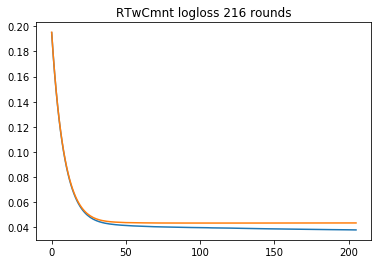

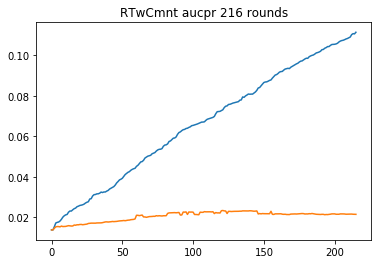

In [42]:
evalres=tgt2res[tgt]['evals_result']
plot_evalres(evalres)

# analyze

## tr vl

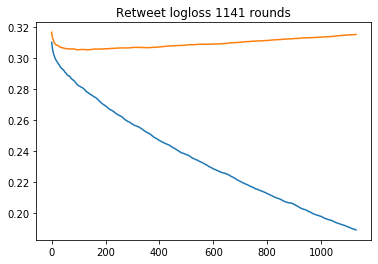

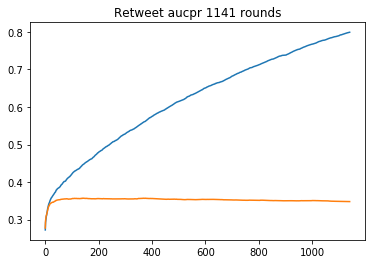

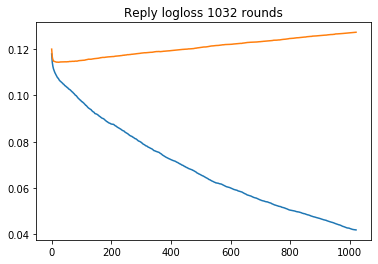

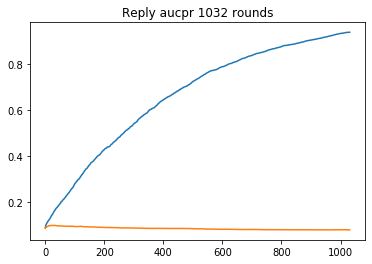

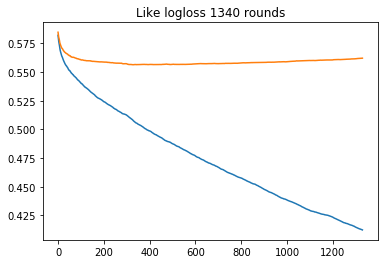

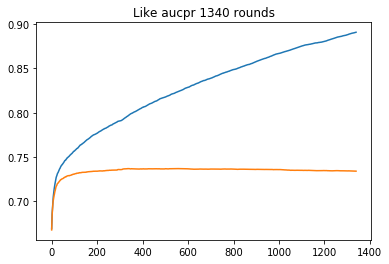

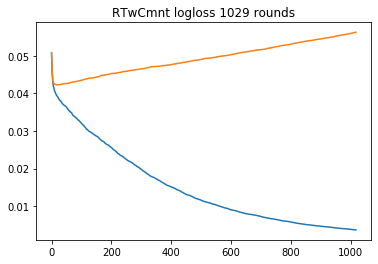

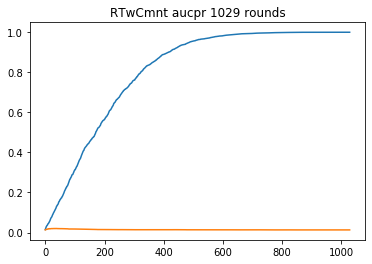

In [43]:
for tgt,res in tgt2res.items():
    evalres=res['evals_result']
    plt.plot(evalres['train']['logloss'][10:])
    plt.plot(evalres['eval']['logloss'][10:])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()

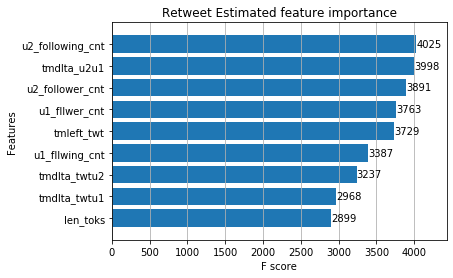

Retweet


,0,1
10,u2_following_cnt,4025
17,tmdlta_u2u1,3998
2,u2_follower_cnt,3891
9,u1_fllwer_cnt,3763
21,tmleft_twt,3729
20,u1_fllwing_cnt,3387
16,tmdlta_twtu2,3237
12,tmdlta_twtu1,2968
6,len_toks,2899
5,tmleft_u2,1769


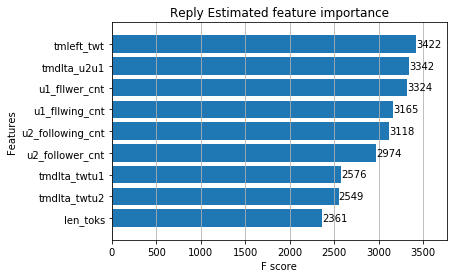

Reply


,0,1
18,tmleft_twt,3422
23,tmdlta_u2u1,3342
4,u1_fllwer_cnt,3324
13,u1_fllwing_cnt,3165
14,u2_following_cnt,3118
6,u2_follower_cnt,2974
8,tmdlta_twtu1,2576
2,tmdlta_twtu2,2549
28,len_toks,2361
9,tmleft_u2,1543


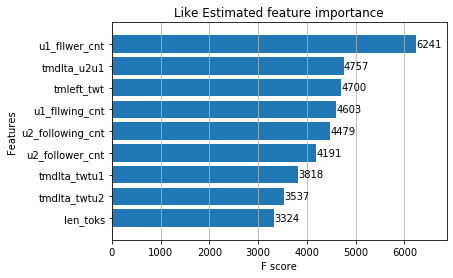

Like


,0,1
9,u1_fllwer_cnt,6241
11,tmdlta_u2u1,4757
23,tmleft_twt,4700
22,u1_fllwing_cnt,4603
7,u2_following_cnt,4479
20,u2_follower_cnt,4191
8,tmdlta_twtu1,3818
18,tmdlta_twtu2,3537
3,len_toks,3324
27,tm_hour,1994


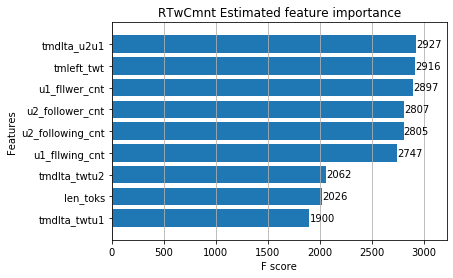

RTwCmnt


,0,1
5,tmdlta_u2u1,2927
10,tmleft_twt,2916
15,u1_fllwer_cnt,2897
0,u2_follower_cnt,2807
13,u2_following_cnt,2805
8,u1_fllwing_cnt,2747
7,tmdlta_twtu2,2062
4,len_toks,2026
18,tmdlta_twtu1,1900
6,tmleft_u2,1458


In [44]:
def show_feat_importance(tgt):
    bst=tgt2res[tgt]['bst']
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    print(tgt)
    display(pd.DataFrame([feat2importance.keys(), 
                          feat2importance.values()]).T.sort_values(1, ascending=False))

for tgt in tgts:
    show_feat_importance(tgt)

In [45]:
for tgt in tgts:
    res=tgt2res[tgt]
    print(tgt)
    prdtr, prdvl = res['prdtr'], res['prdvl']
    ytr, yvl = res['ytr'], res['yvl']
    auc_tr=compute_prauc(prdtr, ytr)
    rce_tr=compute_rce(prdtr, ytr)
    auc_vl=compute_prauc(prdvl, yvl)
    rce_vl=compute_rce(prdvl, yvl)
    res['scrs'] = {
        'auc_tr':auc_tr,
        'rce_tr':rce_tr,
        'auc_vl':auc_vl,
        'rce_vl':rce_vl,
    }    
    print('tr prauc:', f'{auc_tr:.4f}','tr rce:', f'{rce_tr:.4f}', )
    print('vl prauc:', f'{auc_vl:.4f}','vl rce:', f'{rce_vl:.4f}', )

Retweet
tr prauc: 0.4465 tr rce: 20.7933
vl prauc: 0.3570 vl rce: 14.4429
Reply
tr prauc: 0.1640 tr rce: 15.7347
vl prauc: 0.0999 vl rce: 10.8876
Like
tr prauc: 0.7975 tr rce: 26.0075
vl prauc: 0.7370 vl rce: 18.8403
RTwCmnt
tr prauc: 0.1011 tr rce: 13.1145
vl prauc: 0.0197 vl rce: 5.0244


In [46]:
lsttr=[]
lstvl=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    res = tgt2res[tgt]
    if tgt not in tgt2res: continue
    lsttr+=[(f'PRAUC {tgt}',res['scrs']['auc_tr']),
          (f'RCE {tgt}',res['scrs']['rce_tr'])]
    lstvl+=[(f'PRAUC {tgt}',res['scrs']['auc_vl']),
          (f'RCE {tgt}',res['scrs']['rce_vl'])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscr = pd.merge(dfscrtr, dfscrvl, on='metric', suffixes=('tr','vl'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtr,0.446497,20.7933,0.164041,15.7347,0.797456,26.0075,0.101129,13.1145
scrvl,0.357014,14.4429,0.0999423,10.8876,0.737048,18.8403,0.0197414,5.02443


# save results

In [47]:
pickle.dump(col2lang2mean, open(f'{p_out}/col2lang2mean.p', 'wb'))
pickle.dump(cols_feat, open(f"{p_out}/cols_feat.p", "wb"))
pickle.dump(tgt2res, open(f"{p_out}/tgt2res.p", "wb"))

In [28]:
pickle.dump(cols_feat, open(f"{p_out}/cols_feat.p", "wb"))
pickle.dump(tgt2res, open(f"{p_out}/tgt2res.p", "wb"))

# infer

In [48]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)


CPU times: user 10.1 ms, sys: 104 µs, total: 10.2 ms
Wall time: 8.11 ms


In [49]:
%%time
dftst = prpdf(dftst, istrn=False)

CPU times: user 80.3 ms, sys: 717 µs, total: 81 ms
Wall time: 72.1 ms


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


## mean encoding

In [50]:
for col,lang2mean in col2lang2mean.items():
    dftst[f'mean_lang_{col}']  = dftst.lang.map(lang2mean)
dftst.drop(columns='lang',inplace=True)

In [51]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2res[tgt]['bst']
    prdtst = bst.predict(dtst, ntree_limit=bst.best_ntree_limit)
    tgt2prdtst[tgt] = prdtst

2020-04-02 20:41:56 Retweet
2020-04-02 20:41:56 Reply
2020-04-02 20:41:56 Like
2020-04-02 20:41:56 RTwCmnt
CPU times: user 144 ms, sys: 44.1 ms, total: 188 ms
Wall time: 44.2 ms


In [52]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [53]:
%%time
for i,tgt in enumerate(['Retweet','Reply','RTwCmnt','Like',]):
    dfsub = tgt2dfsub[tgt]
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{i}_{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-04-02 20:41:56 Retweet
2020-04-02 20:41:56 Reply
2020-04-02 20:41:56 RTwCmnt
2020-04-02 20:41:56 Like
CPU times: user 182 ms, sys: 23.5 ms, total: 205 ms
Wall time: 15.3 ms
